In [2]:
# Beispiel aus dem IX Artikel

import sys
import pandas as pd
import sklearn
import spacy
import gensim
 
!{sys.executable} -m spacy download de
nlp = spacy.load('de')
doc = nlp("Krafti nein, ich mache hier jetzt selber.")
spacy.displacy.render(doc, style='dep', jupyter=True)

    100% |████████████████████████████████| 38.2MB 2.1MB/s ta 0:00:011  18% |█████▉                          | 7.0MB 1.0MB/s eta 0:00:30    27% |████████▊                       | 10.4MB 1.9MB/s eta 0:00:15    36% |███████████▋                    | 13.8MB 4.3MB/s eta 0:00:06    38% |████████████▏                   | 14.6MB 2.4MB/s eta 0:00:11    46% |███████████████                 | 17.8MB 6.0MB/s eta 0:00:04    74% |███████████████████████▊        | 28.3MB 4.0MB/s eta 0:00:03    74% |███████████████████████▉        | 28.5MB 3.7MB/s eta 0:00:03    76% |████████████████████████▌       | 29.2MB 3.3MB/s eta 0:00:03    86% |███████████████████████████▉    | 33.2MB 2.7MB/s eta 0:00:02    93% |██████████████████████████████  | 35.7MB 2.4MB/s eta 0:00:02
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /home/robinarthur/anaconda3/lib/python3.6/site-packages/de_core_news_s

<h1> einlesen der Daten <h1>

In [3]:
# import von Pandas, Betriebssystemfunktionen als  Bibliotheken laden
import pandas as pd
import json
import os

<h2>Es folgen die Angaben der Speicherorte.<h2>

In [4]:
file_path = './data/'

# try to clean the raw data
# open the data json file and load it into the RAM
with open(file_path + 'data.json') as infile:
    # read the json structure
    d = json.load(infile)
    
    # d is a list of dict objects
    for book in d:
        # every book is a dict
        for key in book.keys():
            # replace the \n - new line character with a whitespace
            book[key] = book[key].replace('\n', ' ')
            # replace some worde with whitespace
            book[key] = book[key].replace('[Fußnote]', ' ')
            
        book['year_dt'] = pd.to_datetime(book['year'], infer_datetime_format=True)
    
            

<h2> Daten in ein speichereffizientes Format bringen <h2>

In [5]:
# put all of the books into an pandas Dataframe
data = pd.DataFrame(d).set_index('number')

<h2>Mit dem folgenden Befehlen verschaffen wir uns einen Überblick über die eingeladenen Daten.<h2>

In [6]:
data  


,name,style,text,year,year_dt
number,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804,1804-01-01
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0001 to 0093
Data columns (total 5 columns):
name       93 non-null object
style      93 non-null object
text       93 non-null object
year       93 non-null object
year_dt    50 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 4.4+ KB


In [8]:
data.describe()

,name,style,text,year,year_dt
count,93,93,93,93,50
unique,93,7,93,24,23
top,An den Frühling,L,Weit in nebelgrauer Ferne Liegt mir das vergan...,,1797-01-01 00:00:00
freq,1,53,1,43,10
first,NaN,NaN,NaN,NaN,1776-01-01 00:00:00
last,NaN,NaN,NaN,NaN,1805-01-01 00:00:00


<h1>NLP<h1>

<h2>Vorbereitung<h2>

Nun benötigen wir die spaCY-Bibliothek und da Modell für die deutsche Sprache.

Mehr zu spaCY: https://spacy.io

In [9]:
import spacy
from spacy.lang.de import German

nlp = spacy.load('de')

Das durch spaCY erzeugte NLP-Objekt ist sehr groß und benötigt viel Speicher. Um das etwas zu entschärfen,
werden nur die benötigen Daten, also Anzahl der Token, Adjektive, Substantive und Verben gespeichert. 
Dabei hilft defaultdict, weil hier alle Werte auf 0 gesetzt sind, das spart viele Fallunterscheidungen.

Die Worte selbst werden auch in ihrer lemmatisierten Form (also grammatikalisch auf die Grundform reduziert)
benötigt, um später Analysen damit durchführen zu können.

In [10]:
%time
from collections import defaultdict

def calculate_the_word_types(data):
    nouns = defaultdict(lambda: 0)
    verbs = defaultdict(lambda: 0)
    adjectives = defaultdict(lambda: 0)

    for i, row in data.iterrows():
        doc = nlp(row["name"] + " " + row["text"])
    data.set_value(i, "nr_token", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ != 'PUNCT', doc)))))
    
    for a in map(lambda x: x.lemma_, filter(lambda x: x.pos_ == 'ADJ', doc)):
        adjectives[a] += 1
    data.set_value(i, "nr_adj", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ == 'ADJ', doc)))))  
    
    for n in map(lambda x: x.lemma_, filter(lambda x: x.pos_ == 'NOUN', doc)):
        nouns[n] +=1
    data.set_value(i, "nr_noun", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ == 'NOUN', doc)))))

    for v in map(lambda x: x.lemma_, filter(lambda x: (x.pos_ == 'AUX') | (x.pos_ == 'VERB'), doc)):
        verbs[v] += 1
    data.set_value(i, "nr_verb", len(list(map(lambda x: x.text, 
                                         filter(lambda x: (x.pos_ == 'AUX') | (x.pos_ == 'VERB'), doc)))))  
    
    return data


###############################################
#
#
#          ACHTUNG DAS AUSFÜHREN DAUERT
#
#
#
#    KNAPP 5 MINUTEN - BITTE das PICKLE laden
#
#               !!!!!!!!!!!!!!!
#
##############################################


data = calculate_the_word_types(data)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [13]:
# save the data into a pickle to save some time


import pickle

# save it
#with open('./data/output_df_wth_nr_token_verb_noun_adj.pickle', 'wb') as handle:
#    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load it
with open('./data/output_df_wth_nr_token_verb_noun_adj.pickle', 'rb') as handle:
    data = pickle.load(handle) 

<h1>Auswertung</h1>

<h2> Wieviel Werke sind pro Jahr in der Datenbank</h2>

In [14]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
#%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
from pandas.plotting import register_matplotlib_converters as rmc
rmc()

In [15]:
# create a schiller style color palette
schiller_type_colors = ['#78C850',  # Grass
                        #'#F08030',  # Fire
                        #'#6890F0',  # Water
                        #'#A8B820',  # Bug
                        #'#A8A878',  # Normal
                        #'#A040A0',  # Poison
                        '#F8D030',  # Electric
                        #'#E0C068',  # Ground
                        #'#EE99AC',  # Fairy
                        '#C03028',  # Fighting
                        #'#F85888',  # Psychic
                        #'#B8A038',  # Rock
                        #'#705898',  # Ghost
                        #'#98D8D8',  # Ice
                        '#7038F8',  # Dragon
                       ]

"\nx_pos = [x for x in range(1776, 1806)]\nprint(x_pos)\n# swarm plot with schiller color palette\nsns.swarmplot(x='year', y='nr_token', data=df,\n             palette=schiller_type_colors)\nplt.xticks(rotation=90)\n# Thus we have to give more margin:\nplt.subplots_adjust(bottom=0.4)\n\nplt.axvline(8, color='r', linestyle='--', lw=2)\nplt.plot()\n"

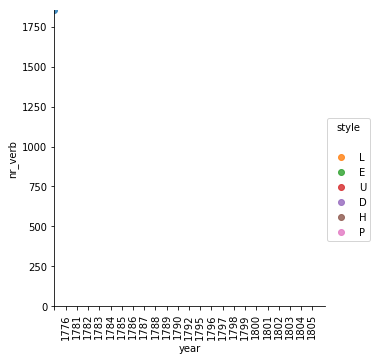

In [16]:
df = data.sort_values(["year"], ascending=True)[["name", "nr_verb", "year", "style"]]

# Plot using Seaborn
sns.lmplot(x='year', y='nr_verb', data=df,
          fit_reg=False,
          hue='style')

# Tweak using Matplotlib
plt.ylim(0, None)
plt.xlim(0, None)
plt.xticks(rotation=90)





"""
x_pos = [x for x in range(1776, 1806)]
print(x_pos)
# swarm plot with schiller color palette
sns.swarmplot(x='year', y='nr_token', data=df,
             palette=schiller_type_colors)
plt.xticks(rotation=90)
# Thus we have to give more margin:
plt.subplots_adjust(bottom=0.4)

plt.axvline(8, color='r', linestyle='--', lw=2)
plt.plot()
"""

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

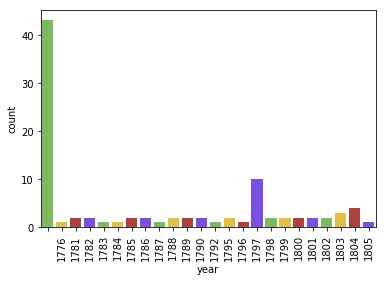

In [17]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='year', data=df, palette= schiller_type_colors)

# Rotate x-labels
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

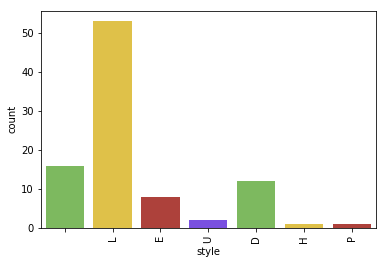

In [18]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='style', data=df, palette= schiller_type_colors)

# Rotate x-labels
plt.xticks(rotation=90)

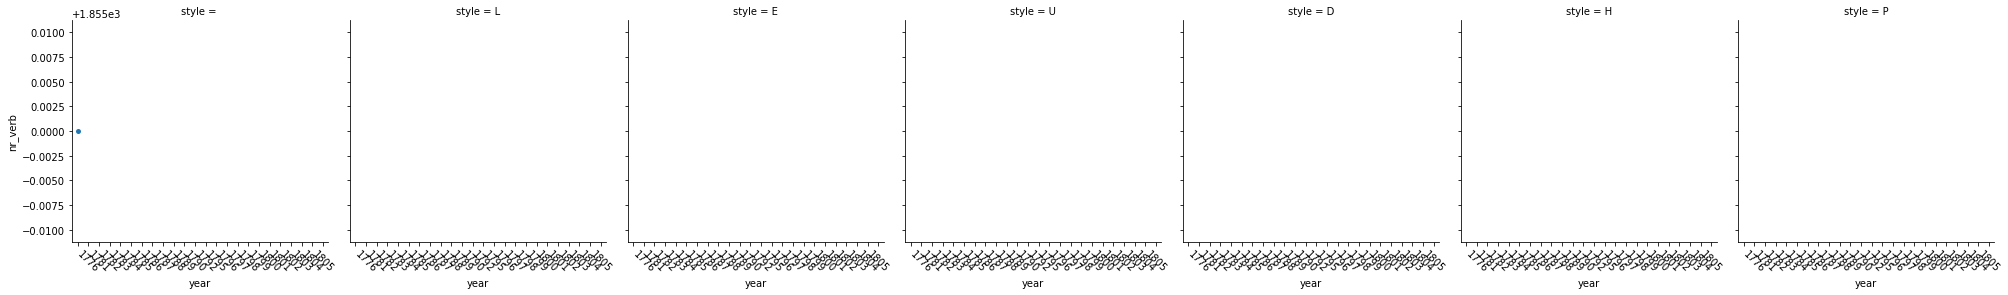

In [19]:
# Factor Plot
g = sns.factorplot(x='year',
                  y='nr_verb',
                  data=df,
                  hue='style', # Color by stage
                  col='style', # Separate by stage
                  kind='swarm') # Swarmplot

# rotate x-axis labels
g.set_xticklabels(rotation=-45)

# Doesn't work because only rotates last plot
# plt.xticks(rotation=-45)

<h2>Verteilung der Textlänge über die Zeit</h2>

Aus dem vorhandenen DataFrame wird nun ein neuer erzeugt, der lediglich die beiden Felder 
year und nr_token besitzt.


In [20]:
text_length = data[["year", "nr_token"]]

Ab jetzt wird es visuell! Die %-Anweisung wird benötigt, damit Jupyter die Plots direkt im Notebook anzeigen kann.
Hier wird matplotlib zur Visualisierung benutzt, die numpy-Bibliothek für die numerische Datenverarbeitung 
wird später noch häufiger benötigt.

Mehr zur Inline-Darstellung in Jupyter: https://ipython.readthedocs.io/en/stable/interactive/plotting.html

Mehr zu matplotlib: https://matplotlib.org

Mehr zu numpy: http://www.numpy.org

Mehr zu set_index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html

Mehr zu agg: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html

Mehr zu rename: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html

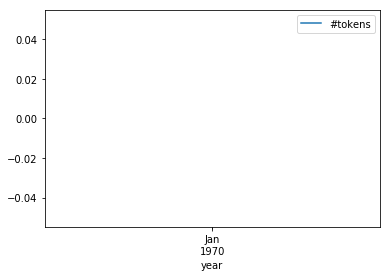

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np


data['year'] = pd.to_datetime(data['year_dt'], errors='coerce')


#data[["year", "nr_token"]].set_index("year").resample('M').agg({'nr_token': 'mean'}).rename(columns={'nr_token': '#tokens'}).plot()
data[["year", "nr_token"]].set_index("year").resample('M').agg({'nr_token': 'mean'}).rename(columns={'nr_token': '#tokens'}).plot()

In [22]:
data

,name,style,text,year,year_dt,nr_token,nr_adj,nr_noun,nr_verb
number,,,,,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805-01-01,1805-01-01,NaN,NaN,NaN,NaN
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790-01-01,1790-01-01,NaN,NaN,NaN,NaN
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803-01-01,1803-01-01,NaN,NaN,NaN,NaN
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804-01-01,1804-01-01,NaN,NaN,NaN,NaN
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801-01-01,1801-01-01,NaN,NaN,NaN,NaN
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781-01-01,1781-01-01,NaN,NaN,NaN,NaN
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783-01-01,1783-01-01,NaN,NaN,NaN,NaN
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788-01-01,1788-01-01,NaN,NaN,NaN,NaN
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784-01-01,1784-01-01,NaN,NaN,NaN,NaN


<h2>Liste der längsten Artikel</h2>

Mehr zur Sortierung: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html

Mehr zur Spaltenauswahl: https://pandas.pydata.org/pandas-docs/stable/indexing.html

In [23]:
data.sort_values(["nr_token"], ascending=False)[["name", "nr_token", "year"]].head(10)

,name,nr_token,year
number,,,
0093,Die Gesetzgebung des Lykurgus und Solon,11089.0,NaT
0001,Demetrius,NaN,1805-01-01
0002,Der versöhnte Menschenfeind,NaN,1790-01-01
0003,Die Braut von Messina,NaN,1803-01-01
0004,Die Huldigung der Künste,NaN,1804-01-01
0005,Die Jungfrau von Orleans,NaN,1801-01-01
0006,Die Räuber,NaN,1781-01-01
0007,Die Verschwörung des Fiesco zu Genua,NaN,1783-01-01
0008,Don Carlos,NaN,1788-01-01


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0001 to 0093
Data columns (total 9 columns):
name        93 non-null object
style       93 non-null object
text        93 non-null object
year        50 non-null datetime64[ns]
year_dt     50 non-null datetime64[ns]
nr_token    1 non-null float64
nr_adj      1 non-null float64
nr_noun     1 non-null float64
nr_verb     1 non-null float64
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 7.3+ KB
